# Imports

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchinfo import summary
import pickle

# Data Handling

In [2]:
X = pd.read_csv('data/gene_data.csv', header=None, index_col=0)
X

,1,2,3,4,5,6,7,8,9,10,...,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967
0,,,,,,,,,,,,,,,,,,,,,
SRR1166318,0,0,1,0,0,4,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
ERR176810,0,0,1,0,2,3,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
ERR181956,0,0,1,0,1,3,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR2100379,0,0,1,0,0,4,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR924706,0,0,1,0,2,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR671746,0,0,1,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
SRR1146372,0,0,2,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ERR176477,0,0,1,0,1,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
Y = pd.read_csv('data/AllLabels.csv', index_col='id')
Y = Y[Y.index.isin(X.index)]
Y

,amikacin,capreomycin,ciprofloxacin,ethambutol,ethionamide,isoniazid,kanamycin,moxifloxacin,ofloxacin,pyrazinamide,rifampicin,streptomycin
id,,,,,,,,,,,,
SRR3675211,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675215,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
SRR3675217,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN
SRR3675218,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN
SRR3675224,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
SRR924705,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924706,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
SRR924707,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [4]:
NoYs = X[np.logical_not(X.index.isin(Y.index))]
print('Xs with no Y found:', NoYs.shape[0])
X = X.drop(NoYs.index)
X = X.sort_index().reset_index().rename(columns={0: 'id'})
Y = Y.sort_index().reset_index()
X_mat = X.iloc[:, 1:].to_numpy()
Y_mat = Y.iloc[:, 1:].to_numpy()

Xs with no Y found: 115


In [5]:
val_test_count = int(X_mat.shape[0] * 0.1)
val_test_indcs = (np.random.permutation(X_mat.shape[0])[:2*val_test_count]).reshape((2, -1))

X_val = X_mat[val_test_indcs[0], :]
Y_val = Y_mat[val_test_indcs[0], :]

X_test = X_mat[val_test_indcs[1], :]
Y_test = Y_mat[val_test_indcs[1], :]

X_train = np.delete(X_mat, val_test_indcs.flatten(), axis=0)
Y_train = np.delete(Y_mat, val_test_indcs.flatten(), axis=0)
print(f'Train Count: {X_train.shape[0]}')
print(f'Validation Count: {X_val.shape[0]}')
print(f'Test Count: {X_test.shape[0]}')

shuffle_indcs = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_indcs, :]
Y_train = Y_train[shuffle_indcs, :]

Train Count: 6277
Validation Count: 784
Test Count: 784


# Utility Functions

In [6]:
def get_acc(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_pred = np.nanmean(y_k_neghbors, axis=1) #y_eval x 12
    y_pred = np.round(y_pred) #0.5 > --> 1

    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval)), np.logical_not(np.isnan(y_pred))))

    return np.sum(y_pred[condition] == y_eval[condition]) / y_eval[condition].shape[0]

In [7]:
def get_acc_weighted(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    nbr_weights = np.exp(-nbr_dists)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_k_neighbors_weighted = y_k_neghbors * nbr_weights.reshape(-1, n_neighbors, 1)
    #y_pred = np.nanmean(y_k_neighbors_weighted, axis=1) #y_eval x 12
    y_pred = np.nansum(y_k_neighbors_weighted, axis=1) / np.sum(nbr_weights.reshape(-1, n_neighbors, 1), axis=1)
    y_pred = np.round(y_pred) #0.5 > --> 1

    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval)), np.logical_not(np.isnan(y_pred))))

    return np.sum(y_pred[condition] == y_eval[condition]) / y_eval[condition].shape[0]

In [8]:
def get_acc_per_drug(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
  emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
  emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
  KNN = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(emb_train)

  nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
  y_k_neghbors = Y_train[nbr_indcs, :] #y_eval x 5 x 12
  y_pred = np.nanmean(y_k_neghbors, axis=1) #y_eval x 12
  y_pred = np.round(y_pred) #0.5 > --> 1

  acc_per_drug = np.zeros(y_eval.shape[1])
  for i in range(y_eval.shape[1]):
    condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval[:, i])), np.logical_not(np.isnan(y_pred[:, i]))))
    acc_per_drug[i] = np.sum(y_pred[condition, i] == y_eval[condition, i]) / y_eval[condition, i].shape[1]
  return acc_per_drug

In [9]:
def get_acc_per_drug_weighted(x_train: np.ndarray, y_train: np.ndarray, x_eval: np.ndarray, y_eval: np.ndarray, model, n_neighbors=5):
    emb_train = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()
    emb_val = model(torch.from_numpy(x_eval.astype('float32'))).detach().numpy()
    KNN = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(emb_train)

    nbr_dists, nbr_indcs = KNN.kneighbors(emb_val)
    nbr_weights = np.exp(-nbr_dists)
    y_k_neghbors = y_train[nbr_indcs, :] #y_eval x 5 x 12
    y_k_neighbors_weighted = y_k_neghbors * nbr_weights.reshape(-1, n_neighbors, 1)
    #y_pred = np.nanmean(y_k_neighbors_weighted, axis=1) #y_eval x 12
    y_pred = np.nansum(y_k_neighbors_weighted, axis=1) / np.sum(nbr_weights.reshape(-1, n_neighbors, 1), axis=1)
    y_pred = np.round(y_pred) #0.5 > --> 1

    acc_per_drug = np.zeros(y_eval.shape[1])
    for i in range(y_eval.shape[1]):
        condition = np.where(np.logical_and(np.logical_not(np.isnan(y_eval[:, i])), np.logical_not(np.isnan(y_pred[:, i]))))
        acc_per_drug[i] = np.sum(y_pred[condition, i] == y_eval[condition, i]) / y_eval[condition, i].shape[1]
    return acc_per_drug

In [10]:
def Similarity_measurement(y_batch_cp, anchor_y, factors):
	y_batch = y_batch_cp.copy()
	y_batch[np.where(y_batch == 0)] = -1
	sims = np.sum((y_batch * (anchor_y*factors)) == 1, axis=1) #/ np.sum(np.logical_or((y_batch * (anchor_y*factors)) == 1, (y_batch * (anchor_y*factors))==-1), axis=1)
	sims[np.where(np.isnan(sims))] = 0
	return sims

In [13]:
def get_triplets(embeddings_tensor, y_batch, max_negatives_per_positive, max_trips_per_anchor, factors):
    triplets = []
    embeddings = embeddings_tensor.detach().numpy()
    num_fine_trips = 0
    num_coarse_trips = 0
    for i in range(embeddings.shape[0]):
        num_anchor_trips = 0
        anchor_emb = embeddings[i, :]
        anchor_y = y_batch[i, :]

        #get similarities
        #sim_scores = np.nansum(y_batch * (anchor_y * factors), axis=1) #dot product similarity
        sim_scores = Similarity_measurement(y_batch, anchor_y, factors) #Equality Similarity

        #get embedding distances
        distances_emb = np.sqrt(np.sum((embeddings - anchor_emb)**2, axis=1))

        #sort similarities w.r.t. distances
        sorted_distances_indcs = np.argsort(distances_emb)
        similarities_sorted_by_distance = sim_scores[sorted_distances_indcs[:50]]

        for pos_sim_limit in reversed(range(y_batch.shape[1])):
            if pos_sim_limit == 0: continue
            positive_indcs = np.nonzero(similarities_sorted_by_distance == pos_sim_limit)[0]
            
            for positive_idx in np.flip(positive_indcs):
                num_negatives = 0
                #Excluding the Anchor
                if sorted_distances_indcs[positive_idx] == i:
                    continue

                positive_similarity = similarities_sorted_by_distance[positive_idx]
                
                #Points with a lower similarity and also a lower distance
                positive_misorderings_condition = np.logical_and(similarities_sorted_by_distance[:positive_idx] < positive_similarity, similarities_sorted_by_distance[:positive_idx] > 0)

                for negative_idx in np.nonzero(positive_misorderings_condition)[0]:
                    triplets.append((i, sorted_distances_indcs[positive_idx], sorted_distances_indcs[negative_idx]))
                    num_anchor_trips += 1
                    num_negatives += 1
                    num_fine_trips +=1
                    if num_negatives > max_negatives_per_positive: break
                
                if num_anchor_trips >= max_trips_per_anchor: break
                zero_condition = np.nonzero(similarities_sorted_by_distance[:positive_idx] == 0)[0]
                if len(zero_condition) == 0: continue
                num_negatives = np.minimum(zero_condition.shape[0], max_negatives_per_positive)
                for _ in range(num_negatives):
                    idx = np.random.randint(len(zero_condition))
                    zero_idx = zero_condition[idx]
                    triplets.append((i, sorted_distances_indcs[positive_idx], sorted_distances_indcs[zero_idx]))
                    num_anchor_trips += 1
                    num_coarse_trips += 1


                if num_anchor_trips >= max_trips_per_anchor: break
            if num_anchor_trips >= max_trips_per_anchor: break
        
    if len(triplets) == 0: return None

    anchors = []
    positives = []
    negatives = []
    for (a,p,n) in triplets:
        anchors.append(embeddings_tensor[a, :].reshape(1, -1))
        positives.append(embeddings_tensor[p, :].reshape(1, -1))
        negatives.append(embeddings_tensor[n, :].reshape(1, -1))
    
    anchors = torch.cat(anchors, dim=0)
    positives = torch.cat(positives, dim=0)
    negatives = torch.cat(negatives, dim=0)
    return anchors, positives, negatives, num_fine_trips, num_coarse_trips, pos_sim_limit

In [14]:
def make_batches(x_mat,y_mat,batch_size,shuffle=True):
	if shuffle:
		shuffled_order=np.random.permutation(x_mat.shape[0])
		x_mat=x_mat[shuffled_order,:]
		y_mat=y_mat[shuffled_order,:]
	train_dataset=[]
	start=0
	while start + batch_size <= x_mat.shape[0]:
		end=min(start+batch_size,x_mat.shape[0])
		train_dataset.append((x_mat[start:end,:],
							y_mat[start:end,:]))
		start+=batch_size
	return train_dataset

In [15]:
def plot_sim_count(
        X_plt, Y_plt, trained_model, untrained_model, inter_threshold=5, intra_threshold=0, max_points_per_sim=1, weighted_radius=False, custom_anchor_idx=None,
        point_rgb_colors = np.array([[(105,41,196)], [(0,93,93)], [(250,77,86)], [(25,128,56)], [(238,83,139)], [(0,157,154)], [(138,56,0)], [(17,146,232)], [(159,24,83)], [(87,4,8)], [(0,45,156)], [(178,134,0)], [(1,39,73)], [(165,110,255)]])/255,
    ):
    point_rgb_colors_with_alpha = np.pad(point_rgb_colors, ((0,0),(0,0), (0, 1)), constant_values=0.25)
    if custom_anchor_idx is not None:
        maxi = custom_anchor_idx
        maxlen = np.unique(np.sum(Y_plt == Y_plt[maxi], axis=1)).shape[0]
        print('Custom Anchor:')
        print(f'Max Similarity Count: {maxlen}')
        print(f'Custom Anchor Index: {maxi}')
    else:
        # Find a good anchor
        maxlen = 0
        maxi = 0
        Y_plt_maskable = np.ma.array(Y_plt, mask=False)
        for i in tqdm(range(Y_plt.shape[0])):
            Y_plt_maskable.mask[i] = True
            sim_uniq, sim_counts = np.unique(np.sum(Y_plt_maskable == Y_plt[i], axis=1), return_counts=True)
            sim_uniq = sim_uniq.compressed()
            if maxlen < sim_uniq.shape[0] and np.all(sim_counts[:-1] > 10):
                maxlen = sim_uniq.shape[0]
                maxi = i
            Y_plt_maskable.mask[i] = False
        print(f'Max Similarity Count: {maxlen}')
        print(f'Best Anchor Index: {maxi}')


    #Seperate each similarity count
    sim_list_indcs = []
    for i in range(maxlen):
        sim_list_indcs.append(np.where(np.sum(Y_plt == Y_plt[maxi], axis=1) == i)[0])


    #TSNE
    emb_plt = trained_model(torch.from_numpy(X_plt.astype('float32'))).detach().numpy()
    tsne_plt = TSNE(n_components=2, metric='euclidean').fit_transform(emb_plt)

    # Sort indcs w.r.t. their distance from anchor
    for i in range(maxlen): 
        criteria = np.argsort(np.linalg.norm(tsne_plt[sim_list_indcs[i]] - tsne_plt[maxi], axis=1))
        sim_list_indcs[i] = sim_list_indcs[i][criteria]

    #Calculate points radius
    if weighted_radius:
        radius = [sim.shape[0] for sim in sim_list_indcs]
        radius = np.array(radius) / np.sum(radius) * 100000
    else:
        radius = [600 for sim in sim_list_indcs]



    
    # Plot
    fig, ax = plt.subplots()
    #prev_norm = np.linalg.norm(tsne_plt[sim_list_indcs[-1][1]] - tsne_plt[maxi]) - inter_threshold
    prev_norm = 0.01
    ax.scatter(tsne_plt[maxi, 0], tsne_plt[maxi, 1], s=600, c=[(0,0,0, 0.5)], edgecolor=[(0,0,0)], linewidths=2.5)
    ax.annotate('A', (tsne_plt[maxi, 0] - 0.7, tsne_plt[maxi, 1] - 1), fontsize= 18)
    selected_points_dict = {'A': (maxi, X.iloc[maxi, 0])}
    for i in reversed(range(maxlen)):
        for j in range(sim_list_indcs[i].shape[0]):
            current_norm = np.linalg.norm(tsne_plt[sim_list_indcs[i][j]] - tsne_plt[maxi])
            if current_norm >= prev_norm + inter_threshold:
                prev_norm = current_norm
                current_centroid = tsne_plt[sim_list_indcs[i][j]]
                selected_points_dict[i] = (sim_list_indcs[i][j], X.iloc[sim_list_indcs[i][j], 0])
                point_count = 0
                while intra_threshold >= np.linalg.norm(tsne_plt[sim_list_indcs[i][j]] - current_centroid) and point_count < max_points_per_sim:
                    ax.scatter(tsne_plt[sim_list_indcs[i][j], 0], tsne_plt[sim_list_indcs[i][j], 1], s=radius[i], c=point_rgb_colors_with_alpha[i], edgecolors=point_rgb_colors[i], linewidths=2.5)
                    ax.annotate(str(i), (tsne_plt[sim_list_indcs[i][j], 0], tsne_plt[sim_list_indcs[i][j], 1]), fontsize=16, horizontalalignment='center', verticalalignment='center')
                    point_count += 1
                    j += 1
                    if j == sim_list_indcs[i].shape[0]: break
                break
    ax.set_title('Visualization of Points in a Trained Model')
    ax.axis('equal')
    fig.set_facecolor('w')
    fig.set_size_inches((16,12))
    fig.savefig('tsne_trained.png', dpi=300)



    ####### plot the same points with no train
    #TSNE
    emb_plt = untrained_model(torch.from_numpy(X_plt.astype('float32'))).detach().numpy()
    tsne_plt = TSNE(n_components=2, metric='euclidean').fit_transform(emb_plt)


    fig, ax = plt.subplots()
    #prev_norm = np.linalg.norm(tsne_plt[sim_list_indcs[-1][1]] - tsne_plt[maxi]) - inter_threshold
    for key in selected_points_dict.keys():
        idx = selected_points_dict[key][0]
        ax.scatter(tsne_plt[idx, 0], tsne_plt[idx, 1], s=radius[key] if key != 'A' else 600, c=point_rgb_colors_with_alpha[key] if key != 'A' else [(0,0,0,0.5)], edgecolors=point_rgb_colors[key] if key != 'A' else [(0,0,0)], linewidths=2.5)
        ax.annotate(str(key), (tsne_plt[idx, 0], tsne_plt[idx, 1]), fontsize=16, horizontalalignment='center', verticalalignment='center')
    ax.set_title('Visualization of the Exact Same Points in an Untrained Model')
    ax.axis('equal')
    fig.set_facecolor('w')
    fig.set_size_inches((16,12))
    fig.savefig('tsne_untrained.png', dpi=300)

    return selected_points_dict

# Model Class

In [16]:
class DeepMetric(torch.nn.Module):
	def __init__(self,input_dim,output_dim,linear_widths):
		super(DeepMetric, self).__init__()
		self.linear_list=torch.nn.ModuleList([])
		assert(input_dim==linear_widths[0])
		assert(output_dim==linear_widths[-1])
		#simple network of successive linear layers
		for i in range(1,len(linear_widths)):
			inp_dim=linear_widths[i-1]
			out_dim=linear_widths[i]
			new_layer=torch.nn.Linear(inp_dim,out_dim)
			#initialize weights and bias    
			torch.nn.init.xavier_normal_(new_layer.weight, gain=1)
			new_layer.bias.data.fill_(0.01)
			self.linear_list.append(new_layer)


	#use relu or sigmoid?
	def forward(self,input_sample):
		x=input_sample
		for layer in self.linear_list:
			x = F.relu(layer(x))
		#normalize to restrict to unit hypersphere as in paper
		x = F.normalize(x, p=2, dim=1)#??
		return x


# Run Everything Above This Line

In [ ]:
# Use this cell to run everything above it

# Main and Training

## Model Instantiation
from the two bellow cells, you have to run one and exactly one of them depending on your case. Please read the first line in each cell.

In [15]:
# ONLY Run if you want to start a new training
model=DeepMetric(X_train.shape[1], 30, [X_train.shape[1], 1500, 30])
loss_list = []
acc_train_list = []
acc_eval_list = []

In [17]:
# Change the Folder Name
# ONLY Run if you want to load a model
model = torch.load('SavedRun/model.pth')
with open('SavedRun/lists.list', 'rb') as f:
  loss_list, acc_train_list, acc_eval_list = pickle.load(f)

In [18]:
# run this cell to make sure your model is ready
summary(model, input_size=(500,X_mat.shape[1]), device='cpu', verbose=0, col_names=['kernel_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
DeepMetric                               --                        --                        --
├─ModuleList: 1-1                        --                        --                        --
│    └─Linear: 2-1                       [3967, 1500]              [500, 1500]               5,952,000
│    └─Linear: 2-2                       [1500, 30]                [500, 30]                 45,030
Total params: 5,997,030
Trainable params: 5,997,030
Non-trainable params: 0
Total mult-adds (G): 3.00
Input size (MB): 7.93
Forward/backward pass size (MB): 6.12
Params size (MB): 23.99
Estimated Total Size (MB): 38.04

## Training Loop
if you chose to load a previously trained model in the previous step, you don't need to run any training and you can skip the next cell. However, if you run the below cell on a previously trained model, it will continue training the model from the last loaded state.

In [19]:
# This is the main training loop. 
# You can stop the training at any time by interrupting the kernel.

# HyperParameters
tmargin=0
batch_size=500
lrate=0.001
max_trips=100
max_neg=3
factors=np.zeros(Y_train.shape[1])+1.0
try:
	for epoch in range(200):	
		print("Epoch ",epoch,(tmargin,batch_size,lrate,max_trips,max_neg))
		# define loss and create optimizer
		triplet_loss = torch.nn.TripletMarginLoss(margin=tmargin, p=2)
		optimizer = torch.optim.Adam(model.parameters(),lr=lrate)
		# get batches
		mini_batches=make_batches(X_train, Y_train, batch_size)
		loss_values=[]
		for batch_num,batch in enumerate(mini_batches):
			x_batch,y_batch=batch
			# generate embeddings
			embeddings=model(torch.from_numpy(x_batch.astype('float32')))
			# generate triplets (online)
			trips=get_triplets(embeddings,y_batch,max_neg,max_trips,factors)
			if trips is None:
				continue
			# anch, pos, neg=trips
			anch, pos, neg, num_fine_trips, num_coarse_trips, last_pos_sim_limit=trips
			# compute loss
			loss_batch=triplet_loss(anch,pos,neg)
			loss_values.append(loss_batch.detach().numpy())
			# backprop
			optimizer.zero_grad()
			loss_batch.backward(retain_graph=True)
			optimizer.step()
			print("Triplets :",anch.shape[0]," - Fine Trips: ",num_fine_trips, " - Coarse Trips:", num_coarse_trips," - Last pos limit: ",last_pos_sim_limit,",- Loss value :",loss_batch.detach().numpy())
		loss_mean=np.mean(np.array(loss_values))
		train_acc = get_acc_weighted(X_train, Y_train, X_train, Y_train, model, n_neighbors=5)
		val_acc = get_acc_weighted(X_train, Y_train, X_val, Y_val, model, n_neighbors=5)
		loss_list.append(loss_mean)
		acc_train_list.append(train_acc)
		acc_eval_list.append(val_acc)
		print("\tTrain Loss for this epoch :",loss_mean)
		print("\tTrain Accuracy for this epoch:", train_acc)
		print("\tValidation Accuracy for this epoch:", val_acc)

		if (epoch+1)%5 == 0:
			#!!!!!!!!!!!!!!!!!!!ATTENTION!!!!!!!!!!!!!!!!!!!!!!!
			#Dont Forget to Copy the Contents of the 'CurrentRun' Folder OR YOU WILL LOOSE YOUR LAST RUN
			torch.save(model, 'CurrentRun/model.pth')
			with open('CurrentRun/lists.list', 'wb') as f:
				pickle.dump((loss_list, acc_train_list, acc_eval_list), f)
			print('model saved!')
		print('='*60)
except KeyboardInterrupt:
	pass

Epoch  0 (0, 500, 0.001, 100, 3)


# Results and Plots
From now on, you need a trained model to run the code and get good plots.

In [22]:
# Getting Test Accuracy
print(f'Test Accuracy: {get_acc_weighted(X_train, Y_train, X_test, Y_test, model, 5):.3f}')

Test Accuracy: 0.878


## Plots

### Loss Over Time

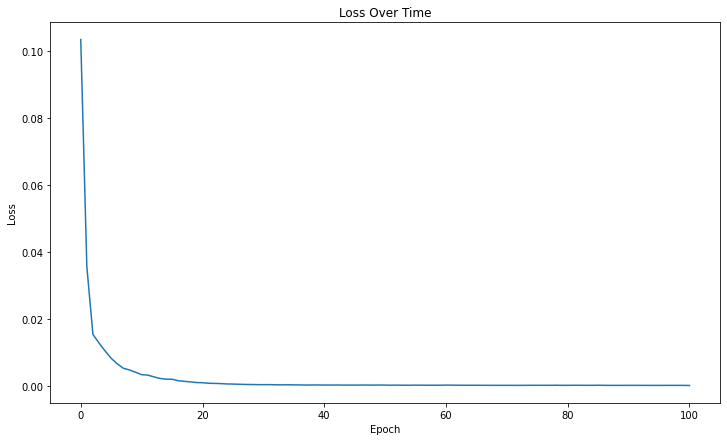

In [18]:
fig, ax = plt.subplots()
x = np.arange(len(loss_list))
y = np.array(loss_list)
ax.plot(x, y)
ax.set_title('Loss Over Time')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.set_size_inches((12,7))
fig.set_facecolor('w')
fig.savefig('Loss.png', dpi=300)

### Point Visualization in Trained and Untrained Models

  0%|          | 0/7845 [00:00<?, ?it/s]

Max Similarity Count: 12
Best Anchor Index: 1514


/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/indirected/Local Disk/University/Work/Sport Analysis/Prediction_ThesisMethod/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 t

{'A': (1514, 'ERR1873439'),
 11: (1560, 'ERR1873497'),
 10: (1586, 'ERR1873529'),
 9: (3883, 'SRR1159129'),
 8: (4911, 'SRR1172144'),
 7: (5606, 'SRR1181093'),
 6: (3440, 'SRR1013623'),
 5: (253, 'ERR1034869'),
 4: (7075, 'SRR2101505'),
 3: (4902, 'SRR1172102'),
 2: (1634, 'ERR190355'),
 1: (3048, 'ERR552742'),
 0: (1437, 'ERR181963')}

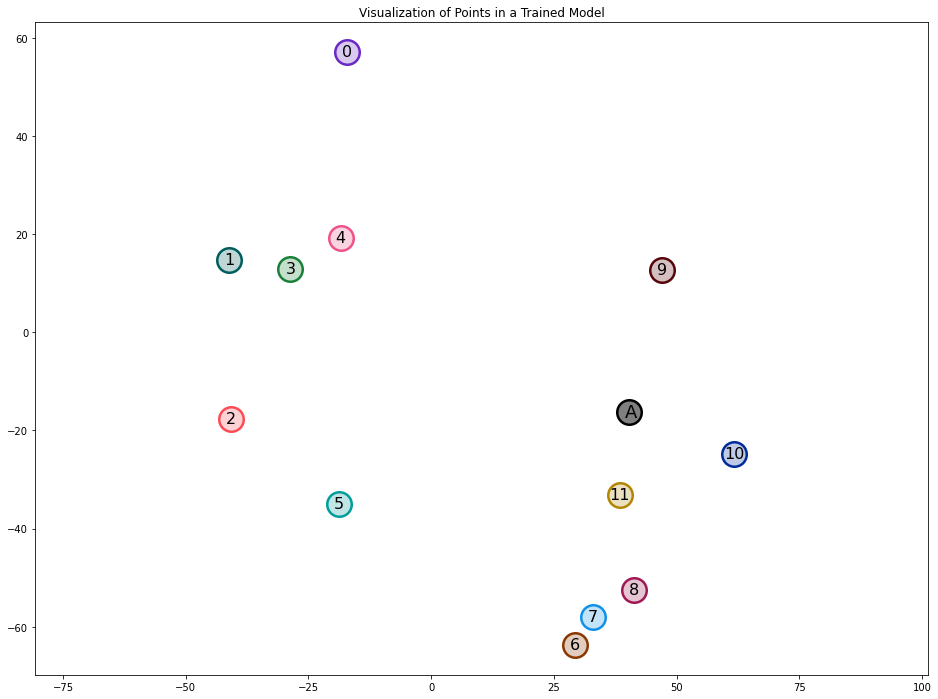

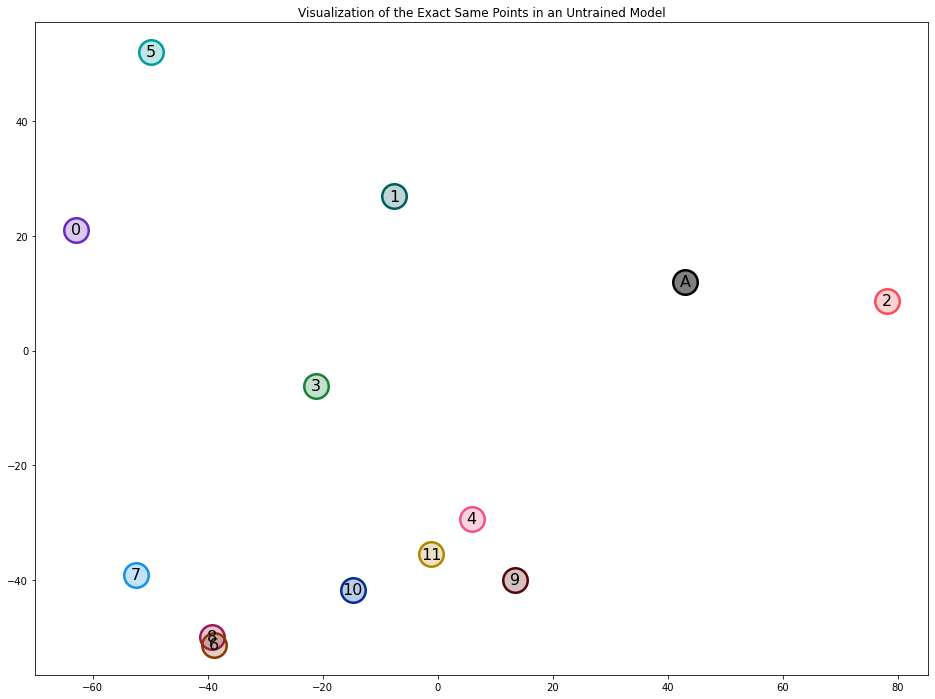

In [19]:
untrained = DeepMetric(X_train.shape[1], 30, [X_train.shape[1], 1500, 30])
plot_sim_count(
    X_mat,
    Y_mat,
    model,
    untrained,
    inter_threshold=6,
    intra_threshold=0,
    max_points_per_sim=1,
    weighted_radius=False
)